In [1]:
import pandas as pd
from  datetime import datetime
import numpy as np
import AppVectorizerModule as ATV

from nltk.corpus import stopwords
from sklearn.decomposition import PCA

from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import KFold
import plotly.plotly as py
import plotly.graph_objs as go
import matplotlib.pyplot as plt
%matplotlib inline  

In [2]:
# Reading data
path='../data/10000users_withgroup.csv'
data= pd.read_csv(path,sep=',',header=0)
print data.columns
df = data[['userid','artist_name','artistid','plays','gender','age','country','dos']]

Index([u'Unnamed: 0', u'userid', u'artistid', u'artist_name', u'plays',
       u'gender', u'age', u'country', u'dos', u'group'],
      dtype='object')


In [3]:
def mapGender(x):
    if x=='m':
        return -1
    else:
        return 1

# Extracts how the number of months from that date to current system date.
def mapDates(d):
    d1= datetime.now()
    d2=datetime.strptime(d, "%b %d, %Y")
    return (d1.year - d2.year)*12 + d1.month - d2.month

def mapAges(x):
    if x>0 and x<=10: #children
        return 0
    elif x>10 and x<=20: #teenagers
        return 2 
    elif x>20 and x<=40: #adults
        return 3
    elif x>40: #old
        return 4

In [4]:
df.gender= map(mapGender,df.gender)
df.dos= map(mapDates,df.dos)
df.age= map(mapAges,df.age)

In [5]:
print len(df.age)
print np.unique(df.age)
df=df.dropna(subset=['age'],how='all')
print len(df.age)
print np.unique(df.age)

488518
[  0.   2.   3. ...,  nan  nan  nan]
386444
[ 0.  2.  3.  4.]


In [6]:
len(df)

386444

In [7]:
len(np.unique(df.userid))

7892

In [8]:
listArtist=pd.DataFrame(df.groupby('userid')['artist_name'].apply(lambda x: "%s" % ' '.join(x))).sort()
sumPlays=pd.DataFrame(df.groupby('userid')['plays'].sum()).sort()
sumPlays=sumPlays.reset_index()

otherFeatures=df[['userid','gender','age','country','dos']]
otherFeatures=otherFeatures.drop_duplicates()
otherFeatures=otherFeatures.sort('userid')
otherFeatures=otherFeatures.reset_index()

In [9]:
listArtist=listArtist.head(1000)
sumPlays=sumPlays.head(1000)
otherFeatures=otherFeatures.head(1000)

In [10]:
# Vectorising the features and merging them to selected numerical features     
min_df=1
max_df=0.9
lowercase=True
stem_vectorizer = ATV.StemmedCountVectorizer(encoding='utf-8',
                                         min_df =min_df,
                                         max_df =max_df,
                                         stop_words='english',
                                         analyzer='word',
                                         lowercase = lowercase)
                
##set filterparameter to your vectorizer
filter_by=["OnlyEng", "AllLang"] #two options are available
count_dialect = True 
stem_vectorizer.setfilter_option(filter_by[1],count_dialect)    

# Vectorizing the Category Column
nArtistName, fmatrix, column_vectorizer = ATV.vectorize_columnTfIdf(listArtist, 'artist_name',stem_vectorizer,listArtist.shape[0],True)
nCountry, fmatrix_2, column_vectorizer_2 = ATV.vectorize_columnTfIdf(otherFeatures,'country',stem_vectorizer,otherFeatures.shape[0],True)

formed dataframe of size:( 1000 , 15014 )
formed dataframe of size:( 1000 , 83 )


In [11]:
final_X=pd.concat([nArtistName,nCountry,sumPlays['plays'],otherFeatures[['dos','gender']]],axis=1)

In [12]:
final_y=otherFeatures[['age']]

In [13]:
print final_X.shape,final_y.shape

(1000, 15100) (1000, 1)


In [25]:
resultpath='../results/'
resultFile=open(resultpath+'Results_Classifier'+'.csv', 'w+')
resultFile.write('Components,Classifier,Accuracy,Precision,Recall')

In [26]:
def getClassifierName(clf):
    if type(clf).__name__ != 'OneVsRestClassifier':
        #print type(clf).__name__
        return type(clf).__name__
    else:
        #print type(clf.estimator).__name__
        return type(clf.estimator).__name__

In [27]:
n_components=[100,500,1000,10000,final_X.shape[1]]
n_kfolds=10

classifiers = [GaussianNB(),RandomForestClassifier(),LogisticRegression(),SGDClassifier()]
classifierName=['GaussianNB','RandomForest','LogisticRegression','SDGC']
#classifiers=[RandomForestClassifier()]
#classifierName=['RandomForest']
n_component_accuracies = []
n_component_precisions = []
for n in n_components:
    xx=final_X.copy()
    pca = PCA(n_components=n)
    xx= pca.fit_transform(xx)
    yy=final_y.values
    print len(xx),len(yy)
    accuracies=[]
    precisions=[]
    for clf in classifiers:
            clfname=getClassifierName(clf)
            #print len(xx),clfname
            print 'Start'+clfname
            kf = KFold(len(final_X),n_kfolds)
            accuracy=0
            precision=0
            recall=0
            for train_index,test_index in kf:
                #print len(train_index),len(test_index)
                X_train, X_test, y_train, y_test = xx[train_index],xx[test_index],yy[train_index],yy[test_index]
                #print len(X_train),len(X_test),len(y_train),len(y_test)
                clf.fit(X_train,y_train)   
                y_pred=clf.predict(X_test)
                accScore=accuracy_score(y_test,y_pred)
                precisionScore=precision_score(y_test,y_pred,pos_label=None)
                recallScore=recall_score(y_test,y_pred,pos_label=None)
                #print("Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0],(y_test != y_pred).sum()))
                accuracy += accScore
                precision += precisionScore
                recall += recallScore
            print("Components:%f Classifier:%s Accuracy Score:%f"%(n,clf,accuracy/n_kfolds)) 
            resultFile.write("\n%f,%s,%0.3f,%0.3f,%0.3f"%(n,clfname,accuracy/n_kfolds,precision/n_kfolds,recall/n_kfolds))
            accuracies.append(accuracy/n_kfolds)
            precisions.append(precision/n_kfolds)
            print 'End'+clfname
    n_component_accuracies.append(accuracies)
    n_component_precisions.append(precisions)
resultFile.close()

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/utils/validation.py:449: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of pr

1000 1000
StartGaussianNB
Components:100.000000 Classifier:GaussianNB() Accuracy Score:0.293000
EndGaussianNB
StartRandomForestClassifier
Components:100.000000 Classifier:RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False) Accuracy Score:0.639000

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/utils/validation.py:449: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of pr


EndRandomForestClassifier
StartLogisticRegression
Components:100.000000 Classifier:LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0) Accuracy Score:0.696000

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/utils/validation.py:449: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of pr


EndLogisticRegression
StartSGDClassifier
Components:100.000000 Classifier:SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False) Accuracy Score:0.173000
EndSGDClassifier
1000

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/utils/validation.py:449: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of pr

 1000
StartGaussianNB
Components:500.000000 Classifier:GaussianNB() Accuracy Score:0.529000

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted


EndGaussianNB
StartRandomForestClassifier
Components:500.000000 Classifier:RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False) Accuracy Score:0.581000

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/utils/validation.py:449: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of pr


EndRandomForestClassifier
StartLogisticRegression
Components:500.000000 Classifier:LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0) Accuracy Score:0.692000

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/utils/validation.py:449: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of pr


EndLogisticRegression
StartSGDClassifier
Components:500.000000 Classifier:SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False) Accuracy Score:0.272000
EndSGDClassifier
1000

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/utils/validation.py:449: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of pr

 1000
StartGaussianNB
Components:1000.000000 Classifier:GaussianNB() Accuracy Score:0.554000

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/home/ayush/Documents/big-data/bigdata-env/lib/python2.7/site-packages/ipykernel/__main__.py:30: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recal


EndGaussianNB
StartRandomForestClassifier
Components:1000.000000 Classifier:RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False) Accuracy Score:0.602000

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/utils/validation.py:449: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of pr


EndRandomForestClassifier
StartLogisticRegression
Components:1000.000000 Classifier:LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0) Accuracy Score:0.697000

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/utils/validation.py:449: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of pr


EndLogisticRegression
StartSGDClassifier
Components:1000.000000 Classifier:SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False) Accuracy Score:0.213000
EndSGDClassifier
1000

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/utils/validation.py:449: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of pr

 1000
StartGaussianNB
Components:10000.000000 Classifier:GaussianNB() Accuracy Score:0.554000

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/utils/validation.py:449: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of pr


EndGaussianNB
StartRandomForestClassifier
Components:10000.000000 Classifier:RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False) Accuracy Score:0.600000

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/utils/validation.py:449: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of pr


EndRandomForestClassifier
StartLogisticRegression
Components:10000.000000 Classifier:LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0) Accuracy Score:0.697000

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/utils/validation.py:449: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of pr


EndLogisticRegression
StartSGDClassifier
Components:10000.000000 Classifier:SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False) Accuracy Score:0.235000
EndSGDClassifier
1000

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/utils/validation.py:449: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of pr

 1000
StartGaussianNB
Components:15100.000000 Classifier:GaussianNB() Accuracy Score:0.554000

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted


EndGaussianNB
StartRandomForestClassifier
Components:15100.000000 Classifier:RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False) Accuracy Score:0.620000

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/utils/validation.py:449: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of pr


EndRandomForestClassifier
StartLogisticRegression
Components:15100.000000 Classifier:LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0) Accuracy Score:0.697000

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/utils/validation.py:449: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of pr


EndLogisticRegression
StartSGDClassifier
Components:15100.000000 Classifier:SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False) Accuracy Score:0.314000
EndSGDClassifier


/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".



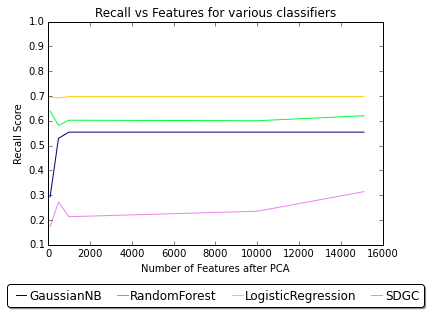

In [28]:
# Plotting the graph
plotarrays=np.array(n_component_accuracies)
data = []
for i in range(0,len(classifiers)):
    a=plotarrays[:,i]
    trace = go.Scatter(
        x = n_components,
        y = a,
        name=classifierName[i]
    )
    data.append(trace)
if(True):
    # Plot using matplotlib
    num_plots = len(classifiers)
    colormap = plt.cm.gist_ncar
    plt.gca().set_color_cycle([colormap(i) for i in np.linspace(0, 0.9, num_plots)])
    # Plot several different functions...
    labels = []
    for i in range(0, num_plots):
        a=plotarrays[:,i]
        #print n_components ,a
        plt.plot(n_components,a)
        labels.append(classifierName[i])

    plt.legend(labels, ncol=4, loc='upper center', 
               bbox_to_anchor=[0.5, -0.15], 
               columnspacing=1.0, labelspacing=0.0,
               handletextpad=0.0, handlelength=1.5,
               fancybox=True, shadow=True)
    x1, x2, y1, y2 = plt.axis()
    plt.axis((x1,x2,y1,1.0))
    plt.xlabel('Number of Features after PCA')
    plt.ylabel('Recall Score')
    plt.title('Recall vs Features for various classifiers')
    
    #plt.show()
    plt.savefig(resultpath+'Result_classifier_recall')

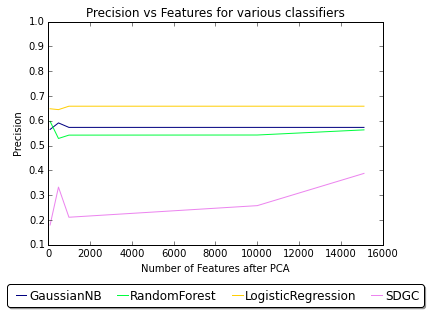

In [29]:
# Plotting the graph
plotarrays=np.array(n_component_precisions)
data = []
for i in range(0,len(classifiers)):
    a=plotarrays[:,i]
    trace = go.Scatter(
        x = n_components,
        y = a,
        name=classifierName[i]
    )
    data.append(trace)
if(True):
    # Plot using matplotlib
    num_plots = len(classifiers)
    colormap = plt.cm.gist_ncar
    plt.gca().set_color_cycle([colormap(i) for i in np.linspace(0, 0.9, num_plots)])
    # Plot several different functions...
    labels = []
    for i in range(0, num_plots):
        a=plotarrays[:,i]
        #print n_components ,a
        plt.plot(n_components,a)
        labels.append(classifierName[i])

    plt.legend(labels, ncol=4, loc='upper center', 
               bbox_to_anchor=[0.5, -0.15], 
               columnspacing=1.0, labelspacing=0.0,
               handletextpad=0.0, handlelength=1.5,
               fancybox=True, shadow=True)
    x1, x2, y1, y2 = plt.axis()
    plt.axis((x1,x2,y1,1.0))
    plt.xlabel('Number of Features after PCA')
    plt.ylabel('Precision')
    plt.title('Precision vs Features for various classifiers')
    
    #plt.show()
    plt.savefig(resultpath+'Result_classifier_precision')